In [28]:
#import the libraries
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
import yfinance as yf

In [27]:
pip install yfinance 

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/1c/19/bf19123baf16a55fd38cbb100b5a49380b9b6db7279987034689d11254c7/yfinance-0.2.32-py2.py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/b6/2c/e391d6d57bbd837d383a6b69b54ecb4768d75b31d8bc7a380b4b4afe4cb2/frozendict-2.3.10-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.9 MB 3.3 MB/s eta 0:00:01
     ------- -------------------------------- 0.6/2.9 MB 7.0 MB/s eta 0:00:01
     -------------- ------------------------- 1.1/2.9 MB 8.7 MB/s eta 0:00:01
     ---------------------- ----------------- 1.7/2.9 MB 9.6 MB/s eta 0:00:01
     ------------------------------ --------- 2.2/2.9 MB 10.1 MB/s eta 0:00:01
     ------------------------------------- -- 2.7/2.9 MB 10.3 MB/s eta 0:00:01
     -----------------------------------

In [43]:
# Read data
Df = yf.download('GLD', '2008-01-01', '2020-6-22', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()
print(Df.head())

[*********************100%%**********************]  1 of 1 completed
                Close
Date                 
2008-01-02  84.860001
2008-01-03  85.570000
2008-01-04  85.129997
2008-01-07  84.769997
2008-01-08  86.779999


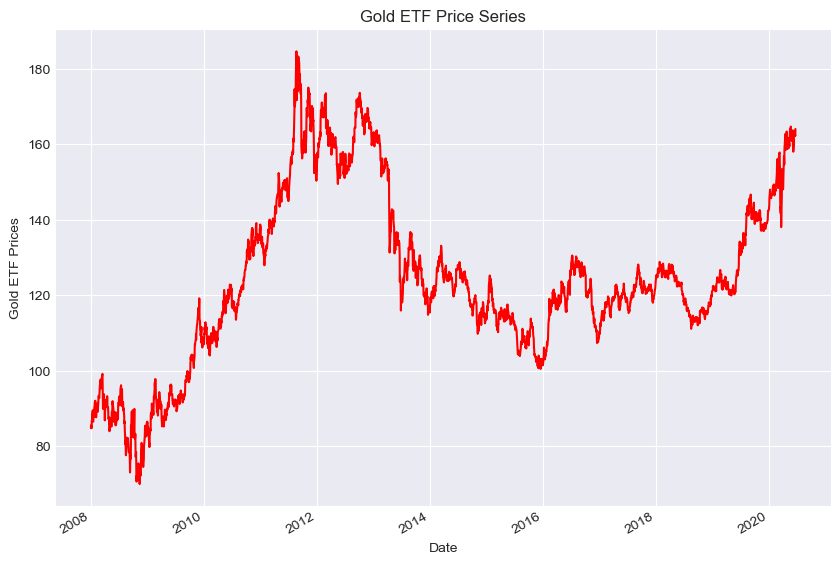

In [42]:
# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [31]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

In [32]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [33]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.20 * 3 Days Moving Average (x1) + -0.21 * 9 Days Moving Average (x2) + 0.43 (constant)


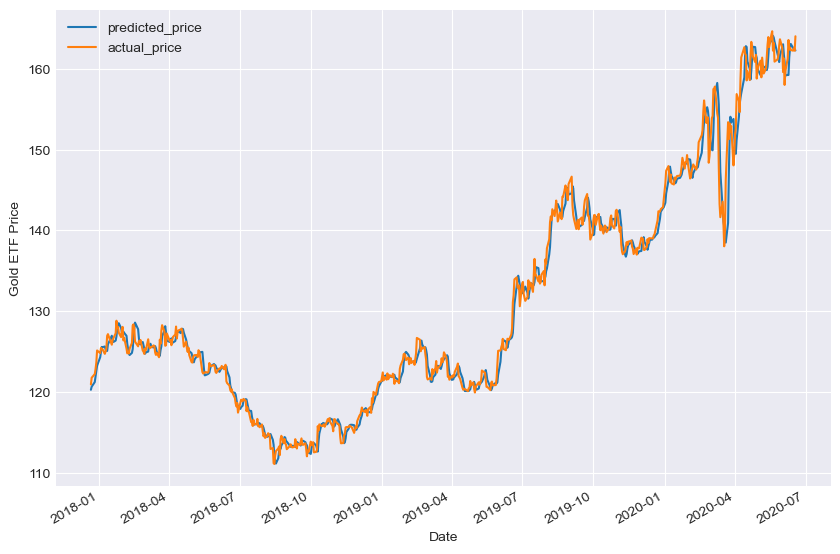

In [34]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

In [35]:
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

98.85

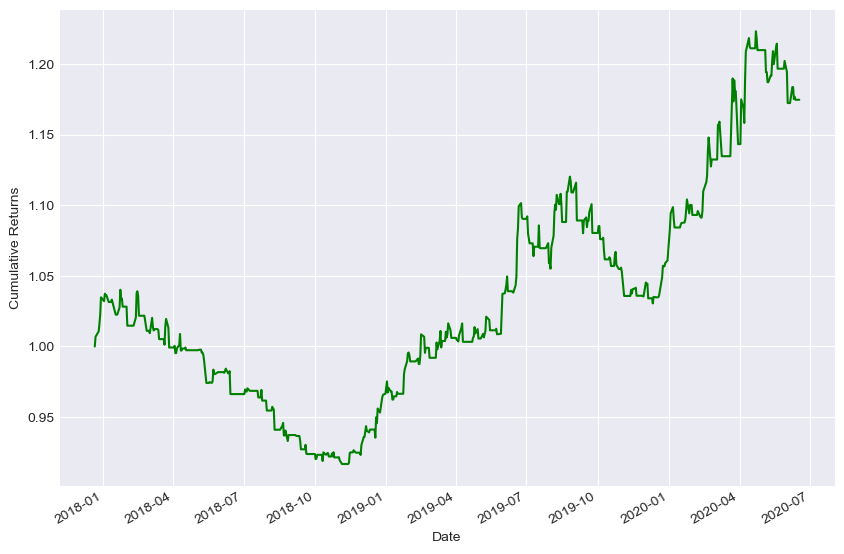

In [36]:
#Plotting cumulative returns
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()


In [37]:
# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 0.73'

In [38]:
# import datetime and get today's date
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%%**********************]  1 of 1 completed


Date,2023-12-05
signal,No Position
predicted_gold_price,189.020816
